In [1]:
import time
from IPython.display import display

notebook_start_time = time.perf_counter()
display("Notebook runtime: 0.00s", display_id="notebook_runtime")

'Notebook runtime: 6.81s'

<DisplayHandle display_id=notebook_runtime>

In [2]:
# Parameters

# Portfolio
asset_names = ["Asset A", "Asset B", "Asset C"]
S0 = [100.0, 90.0, 110.0]
weights = [0.4, 0.3, 0.3]

# Baseline dynamics (synthetic)
mu = [0.05, 0.04, 0.03]
sigma = [0.18, 0.22, 0.16]
corr = [
    [1.0, 0.4, 0.2],
    [0.4, 1.0, 0.3],
    [0.2, 0.3, 1.0],
]

# Horizon / simulation controls
T_years = 1.0
n_steps = 12
n_paths_base = 30_000
seed_base = 123

# Capital metrics
alpha_grid = [0.90, 0.95, 0.975, 0.99]
alpha_focus = 0.99

# Estimation uncertainty
n_paths_grid = [2_000, 5_000, 10_000, 20_000, 50_000]
seeds = [10, 20, 30, 40, 50, 60]

bootstrap_n_paths = 10_000
bootstrap_n_boot = 500
bootstrap_seed = 202

# Correlation stress
corr_rho_stress = [0.0, 0.5, 0.9]
corr_stress_n_paths = 25_000
corr_stress_seed = 777

# Model risk: sigma assumption sensitivity
sigma_multipliers = [0.70, 0.85, 1.00, 1.20, 1.50]
model_risk_n_paths = 25_000
model_risk_seed = 888

# Optional heatmap (keep small for runtime)
heatmap_enabled = True
heatmap_n_paths = 7_500
heatmap_seed = 999

# Optional pricing benchmark sidebar
pricing_benchmark_enabled = True
pricing_n_paths = 80_000
pricing_seed = 321

# 30 Capital & Model Risk (Insurance / Consulting)

This notebook is a compact, **synthetic** stress framework for communicating capital and model risk concepts in an insurance / consulting setting.

We quantify **capital** using tail-focused loss metrics over a horizon `T`:

- **VaR** (high-quantile loss threshold)
- **ES** (average loss beyond VaR)

We then layer on two practical questions:

- **How uncertain are these estimates?** (sampling error / estimator noise)
- **How sensitive are they to modeling assumptions?** (correlation clustering and volatility mis-specification)

All outputs are model-generated under correlated GBM and are **not a backtest**.


**Reading guide (what is and is not being measured)**

- **Capital metrics (VaR/ES)** are computed on a simulated one-period loss distribution over horizon `T`.
- **Estimator uncertainty** quantifies sampling error from finite Monte Carlo runs (and resampling), holding the model fixed.
- **Model risk sensitivities** change assumptions (correlation / volatility) and recompute capital; they are not confidence intervals.

**Outputs**
- Figures are written to `figures/30_capital_and_model_risk/` with stable filenames.
- The notebook is deterministic given the parameter cell seeds.

**Conservative framing**
Treat results as an internal stress lens and communication aid, not as empirical claims.


In [3]:
import os
import sys

parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.risk_metrics import empirical_es, empirical_var, simulate_portfolio_pnl
from src.uncertainty import bootstrap_statistic, ci_from_samples
from src.correlation_stress import stress_corr_offdiag

In [5]:
figures_dir = os.path.join(parent_dir, "figures", "30_capital_and_model_risk")
os.makedirs(figures_dir, exist_ok=True)

plt.style.use("seaborn-v0_8-whitegrid")

# Ensure figures render inline in notebook environments (e.g., VS Code, Jupyter)
try:
    from IPython import get_ipython

    ip = get_ipython()
    if ip is not None:
        ip.run_line_magic("matplotlib", "inline")
except Exception:
    pass
np.set_printoptions(precision=6, suppress=True)

## 1) Context & definition of capital

We work with a terminal portfolio **PnL** over horizon `T`:

- Portfolio value: `V_t = weights · S_t`.
- PnL: `PnL = V_T - V_0`.
- Loss: `L = -PnL` (so larger numbers mean worse outcomes).

Capital metrics (reported as positive numbers):

- **VaR** at confidence `alpha`: the loss level exceeded with probability `1 - alpha`.
- **ES** at confidence `alpha`: the average loss conditional on being in the worst `1 - alpha` tail.

Notes:
- These metrics depend on both the **model** (distribution of `S_T`) and the **estimator** (finite Monte Carlo sample).
- We use empirical (sample) VaR/ES, consistent with `src/risk_metrics.py`.


## 2) Baseline simulation and capital metrics

We simulate terminal PnL under the baseline parameters and compute VaR/ES across a small grid of confidence levels.

What to look for:
- Capital should generally increase with `alpha`.
- ES is typically larger than VaR at the same `alpha` because it averages deeper tail losses.

The baseline section is intentionally simple: one model, one portfolio, and a small set of `alpha` values.


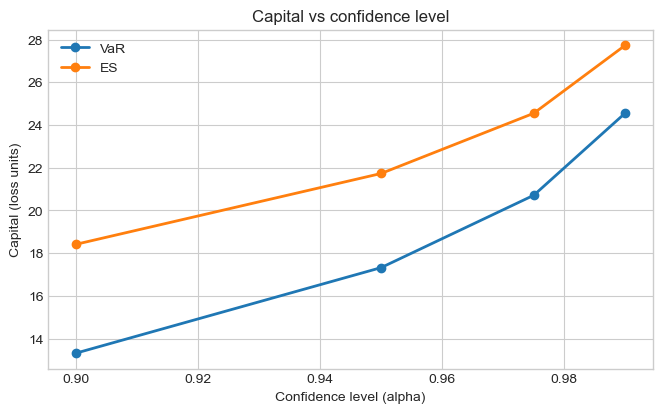

In [6]:
S0_arr = np.asarray(S0, dtype=float)
weights_arr = np.asarray(weights, dtype=float)
mu_arr = np.asarray(mu, dtype=float)
sigma_arr = np.asarray(sigma, dtype=float)
corr_arr = np.asarray(corr, dtype=float)

pnl = simulate_portfolio_pnl(
    S0=S0_arr,
    mu=mu_arr,
    sigma=sigma_arr,
    corr_matrix=corr_arr,
    weights=weights_arr,
    T=T_years,
    n_steps=n_steps,
    n_paths=n_paths_base,
    seed=seed_base,
)
loss = -pnl

rows = []
for a in alpha_grid:
    rows.append(
        {
            "alpha": float(a),
            "VaR": empirical_var(pnl, alpha=float(a)),
            "ES": empirical_es(pnl, alpha=float(a)),
        }
    )

capital_df = pd.DataFrame(rows).set_index("alpha")
capital_df

fig, ax = plt.subplots(figsize=(7.8, 4.4))
ax.plot(capital_df.index, capital_df["VaR"], marker="o", linewidth=2.0, label="VaR")
ax.plot(capital_df.index, capital_df["ES"], marker="o", linewidth=2.0, label="ES")
ax.set_title("Capital vs confidence level")
ax.set_xlabel("Confidence level (alpha)")
ax.set_ylabel("Capital (loss units)")
ax.legend(loc="upper left")

path = os.path.join(figures_dir, "capital_vs_alpha.png")
fig.savefig(path, dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)

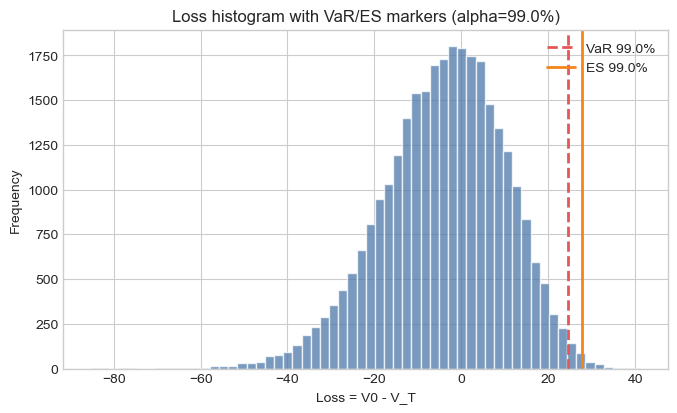

In [7]:
var_focus = empirical_var(pnl, alpha=alpha_focus)
es_focus = empirical_es(pnl, alpha=alpha_focus)

fig, ax = plt.subplots(figsize=(7.8, 4.4))
ax.hist(loss, bins=60, color="#4c78a8", alpha=0.75, edgecolor="white")
ax.axvline(
    var_focus, color="#e45756", linestyle="--", linewidth=2.0, label=f"VaR {alpha_focus:.1%}"
)
ax.axvline(es_focus, color="#f58518", linestyle="-", linewidth=2.0, label=f"ES {alpha_focus:.1%}")
ax.set_title(f"Loss histogram with VaR/ES markers (alpha={alpha_focus:.1%})")
ax.set_xlabel("Loss = V0 - V_T")
ax.set_ylabel("Frequency")
ax.legend(loc="upper right")

path = os.path.join(figures_dir, "loss_hist_with_var_es.png")
fig.savefig(path, dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)

**Quick consistency checks**

- The VaR/ES markers should land in the right tail of the **loss** histogram.
- ES should generally be **>= VaR** at the same `alpha`.
- If results look unstable, the next section quantifies how much is sampling error vs. signal.


## 3) Estimation uncertainty

Monte Carlo capital estimates have sampling error, especially in the far tail.

We show uncertainty two complementary ways:

A) **Repeated seeds** (across independent simulations):
- For each `n_paths`, run multiple seeds and measure variability in the resulting VaR/ES estimates.
- This is a practical way to visualize how many paths are needed for stability at a chosen `alpha`.

B) **Bootstrap CI** (conditional on a single simulated sample):
- Resample the loss (or PnL) sample with replacement and recompute VaR/ES.
- The resulting interval is an estimator diagnostic; it does **not** address model risk.

These are workflow tools to quantify estimator noise, not a substitute for model validation.


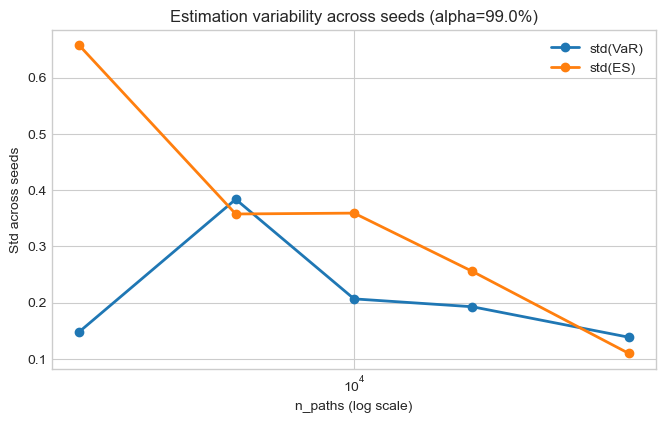

In [8]:
var_by_paths = []
es_by_paths = []

for n_paths in n_paths_grid:
    vars_ = []
    ess_ = []
    for s in seeds:
        pnl_s = simulate_portfolio_pnl(
            S0=S0_arr,
            mu=mu_arr,
            sigma=sigma_arr,
            corr_matrix=corr_arr,
            weights=weights_arr,
            T=T_years,
            n_steps=n_steps,
            n_paths=int(n_paths),
            seed=int(s),
        )
        vars_.append(empirical_var(pnl_s, alpha=alpha_focus))
        ess_.append(empirical_es(pnl_s, alpha=alpha_focus))

    var_by_paths.append(np.std(vars_, ddof=1))
    es_by_paths.append(np.std(ess_, ddof=1))

std_df = pd.DataFrame(
    {
        "n_paths": n_paths_grid,
        "std_VaR": var_by_paths,
        "std_ES": es_by_paths,
    }
).set_index("n_paths")
std_df

fig, ax = plt.subplots(figsize=(7.8, 4.4))
ax.plot(std_df.index, std_df["std_VaR"], marker="o", linewidth=2.0, label="std(VaR)")
ax.plot(std_df.index, std_df["std_ES"], marker="o", linewidth=2.0, label="std(ES)")
ax.set_xscale("log")
ax.set_title(f"Estimation variability across seeds (alpha={alpha_focus:.1%})")
ax.set_xlabel("n_paths (log scale)")
ax.set_ylabel("Std across seeds")
ax.legend(loc="upper right")

path = os.path.join(figures_dir, "capital_std_vs_paths.png")
fig.savefig(path, dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)

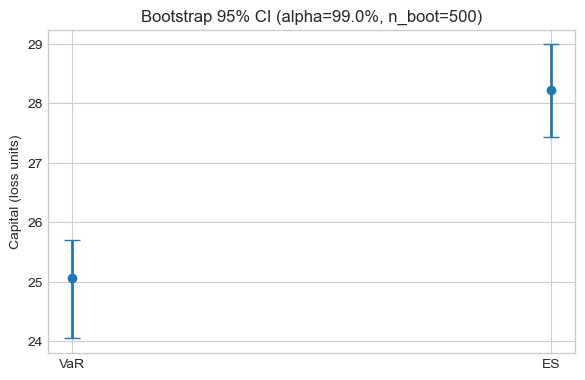

In [9]:
pnl_boot = simulate_portfolio_pnl(
    S0=S0_arr,
    mu=mu_arr,
    sigma=sigma_arr,
    corr_matrix=corr_arr,
    weights=weights_arr,
    T=T_years,
    n_steps=n_steps,
    n_paths=bootstrap_n_paths,
    seed=seed_base,
)

var_hat = empirical_var(pnl_boot, alpha=alpha_focus)
es_hat = empirical_es(pnl_boot, alpha=alpha_focus)

var_reps = bootstrap_statistic(
    pnl_boot,
    stat_fn=lambda x: empirical_var(x, alpha=alpha_focus),
    n_boot=bootstrap_n_boot,
    seed=bootstrap_seed,
)
es_reps = bootstrap_statistic(
    pnl_boot,
    stat_fn=lambda x: empirical_es(x, alpha=alpha_focus),
    n_boot=bootstrap_n_boot,
    seed=bootstrap_seed,
)

var_lo, var_hi = ci_from_samples(var_reps, alpha=0.05)
es_lo, es_hi = ci_from_samples(es_reps, alpha=0.05)

ci_df = pd.DataFrame(
    {
        "point": [var_hat, es_hat],
        "lo": [var_lo, es_lo],
        "hi": [var_hi, es_hi],
    },
    index=["VaR", "ES"],
)
ci_df

fig, ax = plt.subplots(figsize=(6.8, 4.2))
x = np.arange(2)
y = ci_df["point"].values
yerr = np.vstack([y - ci_df["lo"].values, ci_df["hi"].values - y])
ax.errorbar(x, y, yerr=yerr, fmt="o", capsize=6, linewidth=2.0, color="#1f77b4")
ax.set_xticks(x)
ax.set_xticklabels(ci_df.index)
ax.set_title(f"Bootstrap 95% CI (alpha={alpha_focus:.1%}, n_boot={bootstrap_n_boot})")
ax.set_ylabel("Capital (loss units)")

path = os.path.join(figures_dir, "bootstrap_ci_var_es.png")
fig.savefig(path, dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)

**How to use these uncertainty views**

- The repeated-seed plot answers: *How many paths do we need before the estimate is stable enough for the decision at hand?*
- The bootstrap CI answers: *Given one simulated loss sample, how variable is the VaR/ES estimator?*

If the estimator uncertainty is large relative to the differences between scenarios, treat comparisons as inconclusive without more paths (or alternative variance reduction / modeling choices).


## 4) Correlation stress impact on capital

Correlation increases can **cluster losses** across assets and inflate tail risk even if marginal volatilities are unchanged.

For a small demo portfolio, we apply a transparent stress:
- Set all off-diagonal correlations to a target `rho` (diagonal stays 1).

This is not a claim about how correlations behave in reality; it is a simple stress lens to isolate the effect of dependence on capital metrics.


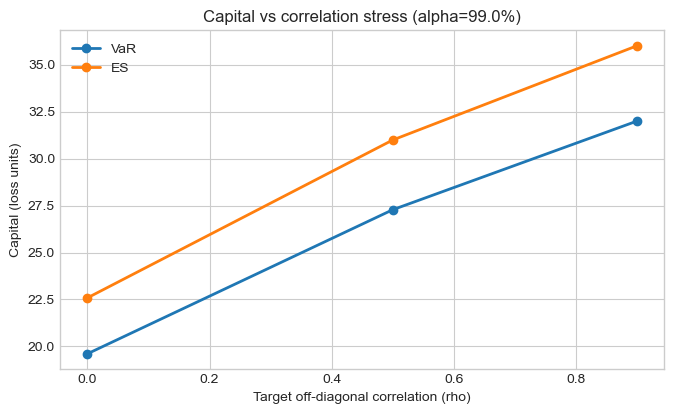

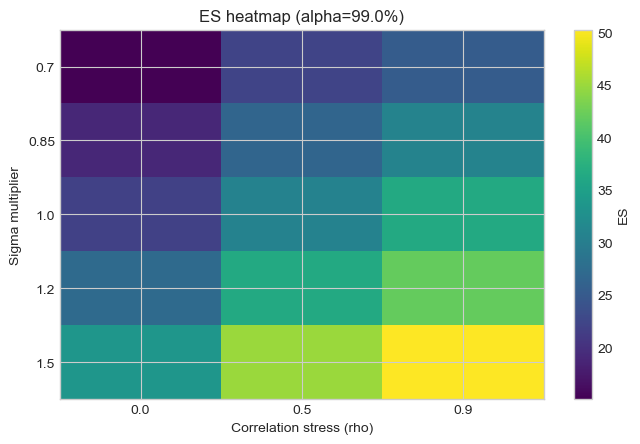

In [10]:
corr_stress_rows = []

for rho in corr_rho_stress:
    corr_stressed = stress_corr_offdiag(corr_arr, target_rho=float(rho))
    pnl_r = simulate_portfolio_pnl(
        S0=S0_arr,
        mu=mu_arr,
        sigma=sigma_arr,
        corr_matrix=corr_stressed,
        weights=weights_arr,
        T=T_years,
        n_steps=n_steps,
        n_paths=corr_stress_n_paths,
        seed=corr_stress_seed,
    )
    corr_stress_rows.append(
        {
            "rho": float(rho),
            "VaR": empirical_var(pnl_r, alpha=alpha_focus),
            "ES": empirical_es(pnl_r, alpha=alpha_focus),
        }
    )

corr_capital_df = pd.DataFrame(corr_stress_rows).set_index("rho")
corr_capital_df

fig, ax = plt.subplots(figsize=(7.8, 4.4))
ax.plot(corr_capital_df.index, corr_capital_df["VaR"], marker="o", linewidth=2.0, label="VaR")
ax.plot(corr_capital_df.index, corr_capital_df["ES"], marker="o", linewidth=2.0, label="ES")
ax.set_title(f"Capital vs correlation stress (alpha={alpha_focus:.1%})")
ax.set_xlabel("Target off-diagonal correlation (rho)")
ax.set_ylabel("Capital (loss units)")
ax.legend(loc="upper left")

path = os.path.join(figures_dir, "capital_vs_correlation.png")
fig.savefig(path, dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)

if heatmap_enabled:
    heat = np.empty((len(sigma_multipliers), len(corr_rho_stress)), dtype=float)
    for i, m in enumerate(sigma_multipliers):
        for j, rho in enumerate(corr_rho_stress):
            corr_stressed = stress_corr_offdiag(corr_arr, target_rho=float(rho))
            pnl_h = simulate_portfolio_pnl(
                S0=S0_arr,
                mu=mu_arr,
                sigma=sigma_arr * float(m),
                corr_matrix=corr_stressed,
                weights=weights_arr,
                T=T_years,
                n_steps=n_steps,
                n_paths=heatmap_n_paths,
                seed=heatmap_seed + 31 * i + 7 * j,
            )
            heat[i, j] = empirical_es(pnl_h, alpha=alpha_focus)

    fig, ax = plt.subplots(figsize=(7.8, 4.8))
    im = ax.imshow(heat, aspect="auto", cmap="viridis")
    ax.set_title(f"ES heatmap (alpha={alpha_focus:.1%})")
    ax.set_xlabel("Correlation stress (rho)")
    ax.set_ylabel("Sigma multiplier")
    ax.set_xticks(np.arange(len(corr_rho_stress)))
    ax.set_xticklabels([str(r) for r in corr_rho_stress])
    ax.set_yticks(np.arange(len(sigma_multipliers)))
    ax.set_yticklabels([str(m) for m in sigma_multipliers])
    fig.colorbar(im, ax=ax, label="ES")

    path = os.path.join(figures_dir, "es_heatmap_sigma_vs_corr.png")
    fig.savefig(path, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close(fig)

**Transition: dependence risk vs. parameter risk**

Correlation stress changes *how losses co-move* across the portfolio. The next section changes *how volatile each asset is* (sigma multipliers). Both are common, high-impact model-risk levers in capital discussions.


## 5) Model risk: sigma assumption sensitivity

A compact model-risk lens is volatility mis-specification.

Holding portfolio composition, horizon, and correlations fixed, we sweep `sigma` multipliers and recompute VaR/ES at `alpha=0.99`.

Interpretation:
- This is a **sensitivity analysis**, not a confidence interval.
- It answers: *If volatility were 15% higher/lower than assumed, how much would capital move?*


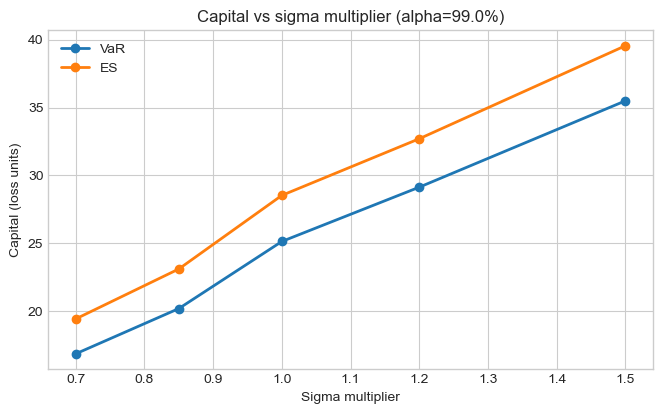

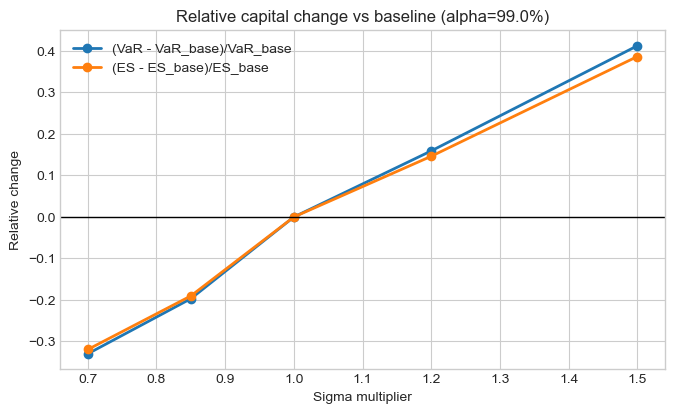

In [11]:
sigma_rows = []
for m in sigma_multipliers:
    pnl_m = simulate_portfolio_pnl(
        S0=S0_arr,
        mu=mu_arr,
        sigma=sigma_arr * float(m),
        corr_matrix=corr_arr,
        weights=weights_arr,
        T=T_years,
        n_steps=n_steps,
        n_paths=model_risk_n_paths,
        seed=model_risk_seed + int(1000 * float(m)),
    )
    sigma_rows.append(
        {
            "sigma_mult": float(m),
            "VaR": empirical_var(pnl_m, alpha=alpha_focus),
            "ES": empirical_es(pnl_m, alpha=alpha_focus),
        }
    )

sigma_df = pd.DataFrame(sigma_rows).set_index("sigma_mult")
sigma_df

fig, ax = plt.subplots(figsize=(7.8, 4.4))
ax.plot(sigma_df.index, sigma_df["VaR"], marker="o", linewidth=2.0, label="VaR")
ax.plot(sigma_df.index, sigma_df["ES"], marker="o", linewidth=2.0, label="ES")
ax.set_title(f"Capital vs sigma multiplier (alpha={alpha_focus:.1%})")
ax.set_xlabel("Sigma multiplier")
ax.set_ylabel("Capital (loss units)")
ax.legend(loc="upper left")

path = os.path.join(figures_dir, "capital_vs_sigma_multiplier.png")
fig.savefig(path, dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)

base_idx = float(1.0)
var_base = (
    float(sigma_df.loc[base_idx, "VaR"])
    if base_idx in sigma_df.index
    else float(sigma_df.iloc[np.argmin(np.abs(sigma_df.index - 1.0))]["VaR"])
)
es_base = (
    float(sigma_df.loc[base_idx, "ES"])
    if base_idx in sigma_df.index
    else float(sigma_df.iloc[np.argmin(np.abs(sigma_df.index - 1.0))]["ES"])
)

rel_df = pd.DataFrame(
    {
        "VaR_rel": (sigma_df["VaR"] - var_base) / var_base,
        "ES_rel": (sigma_df["ES"] - es_base) / es_base,
    },
    index=sigma_df.index,
)
rel_df

fig, ax = plt.subplots(figsize=(7.8, 4.4))
ax.plot(
    rel_df.index, rel_df["VaR_rel"], marker="o", linewidth=2.0, label="(VaR - VaR_base)/VaR_base"
)
ax.plot(rel_df.index, rel_df["ES_rel"], marker="o", linewidth=2.0, label="(ES - ES_base)/ES_base")
ax.axhline(0.0, color="black", linewidth=1.0)
ax.set_title(f"Relative capital change vs baseline (alpha={alpha_focus:.1%})")
ax.set_xlabel("Sigma multiplier")
ax.set_ylabel("Relative change")
ax.legend(loc="upper left")

path = os.path.join(figures_dir, "capital_relative_change.png")
fig.savefig(path, dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)

## 6) Triangulation / benchmark note (optional)

If available, we include a small pricing cross-check for a single vanilla option:

- Black-Scholes closed-form
- PDE (Crank-Nicolson)
- Monte Carlo (with variance reduction)

This is **not** validation of VaR/ES or capital. It is a narrow sanity check that independent pricing implementations agree under shared assumptions.


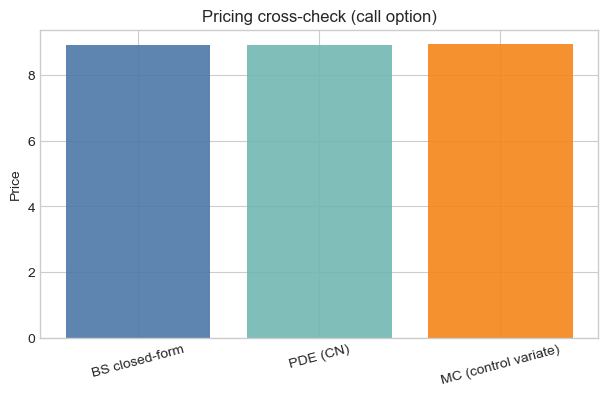

In [12]:
if pricing_benchmark_enabled:
    try:
        from src.pde_bs_fd import price_bs_pde_cn
        from src.pricing import black_scholes_call, mc_european_call

        S0_opt = 100.0
        K_opt = 100.0
        T_opt = 1.0
        r_opt = 0.02
        sigma_opt = 0.20

        bs = black_scholes_call(S0_opt, K_opt, T_opt, r_opt, sigma_opt)
        pde = price_bs_pde_cn(S0_opt, K_opt, T_opt, r_opt, sigma_opt, option_type="call")
        mc = mc_european_call(
            S0=S0_opt,
            K=K_opt,
            T=T_opt,
            r=r_opt,
            sigma=sigma_opt,
            n_steps=252,
            n_paths=pricing_n_paths,
            seed=pricing_seed,
            variance_reduction="control_variate",
            return_details=True,
        )

        price_df = pd.DataFrame(
            {
                "price": [bs, pde, mc.price],
            },
            index=["BS closed-form", "PDE (CN)", "MC (control variate)"],
        )
        price_df

        fig, ax = plt.subplots(figsize=(7.2, 4.0))
        ax.bar(
            price_df.index, price_df["price"], color=["#4c78a8", "#72b7b2", "#f58518"], alpha=0.9
        )
        ax.set_title("Pricing cross-check (call option)")
        ax.set_ylabel("Price")
        ax.tick_params(axis="x", rotation=15)

        path = os.path.join(figures_dir, "pde_vs_bs_vs_mc_price.png")
        fig.savefig(path, dpi=150, bbox_inches="tight")
        plt.show()
        plt.close(fig)
    except Exception as e:
        display(f"Pricing benchmark skipped: {e}")

## 7) Interpretation & limitations

Key drivers shown here:
- Higher confidence (`alpha`) increases capital; **ES typically grows faster than VaR** as it reflects deeper tail severity.
- Higher correlations increase tail risk via **loss clustering**.
- Volatility assumptions (`sigma`) can materially shift VaR/ES (a simple model risk lens).
- Estimation uncertainty is non-trivial at small `n_paths`, especially for ES.

Limitations (explicit):
- Correlated GBM is a simplified model (no fat tails, jumps, regime switching, liquidity effects, or dynamic correlations).
- Stress choices are illustrative; they are not calibrated.
- Deterministic seeds make results reproducible, not predictive.


In [13]:
from IPython.display import update_display

elapsed = time.perf_counter() - notebook_start_time
update_display(f"Notebook runtime: {elapsed:.2f}s", display_id="notebook_runtime")